## Sentiment Analysis: Modeling Amazon Reviews with FastAI

### Preliminaries

In [1]:
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
import pandas as pd
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [34]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [35]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), pct_dec=2, dpi=80):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.{}f%%\n%d/%d'.format(pct_dec) % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.{}f%%\n%d'.format(pct_dec) % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax, square = True, cmap = 'PuBu', cbar_kws = {'label':'Percentage'}, vmin = 0, vmax = 100) # Change cm_perc to cm if coloring is by %
    fig.set_dpi(dpi)
    
    plt.show()

### Load and Preprocess Data

We will modeling [Amazon Reviews](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt), using only 100,000 reviews from the **Wireless** category so that we have a relatively 'small' dataset.<br>
The **classification/sentiment analysis task**: given an Amazon review (review headline + review body), predict the star rating from 1-5.

In [2]:
df_amazon = pd.read_csv('data/text/amazon_reviews_us_Wireless_v1_00.tsv.gz',
                        sep='\t',
                        compression='gzip',
                        usecols=['review_headline','review_body','star_rating'],
                        error_bad_lines=False,
                        warn_bad_lines=False)
df_amazon = df_amazon.dropna()
df_amazon = df_amazon.sample(100000, random_state=2020)

Let's perform some preprocessing:
- remove punctuation marks
- replace whitespace and '-' or '/' characters with spaces
- convert star ratings to integer

In [3]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    return reviews

df_amazon.loc[:,'review'] = df_amazon['review_headline'] + ' ' + df_amazon['review_body']
df_amazon.loc[:,'review'] = preprocess_reviews(df_amazon.review)
df_amazon.loc[:,'star_rating'] = df_amazon.star_rating.astype(int)

In [42]:
df_amazon.sample(10, random_state=2020)

,star_rating,review_headline,review_body,review
1792302,5,Five Stars,"Thanks, this is a true value. Stylus is short...",five stars thanks this is a true value stylus...
7967590,5,grandaughter loves it,This is the second phone case I bought for my ...,grandaughter loves it this is the second phone...
6647536,1,screen and body,Not the greatest screen protector but for .99 ...,screen and body not the greatest screen protec...
6414044,4,its ok,Im very pleased with the product it does it jo...,its ok im very pleased with the product it doe...
7701488,5,A++,+ + + + + LOVE THIS PRODUCT IT'S AMAZING + + +...,a++ + + + + + love this product its amazing + ...
2437007,5,Love it!,"I love it, works perfect. You can see on this ...",love it i love it works perfect you can see on...
6735977,4,Polka dot gel case,It's very cute. Easy to get off and on. I like...,polka dot gel case its very cute easy to get o...
5885602,5,My items I purchased,I loved this case and it fits real well on my ...,my items i purchased i loved this case and it ...
1546974,5,Love the colors,Love the colors! Offers a secure connection w...,love the colors love the colors offers a secu...
3278886,2,Two Stars,It did not fit properly in my car.,two stars it did not fit properly in my car


In [64]:
df_ct_pct = pd.concat([df_amazon.star_rating.value_counts().rename('Count'),
                       df_amazon.star_rating.value_counts(normalize=True).rename('Percent')*100], axis=1)
df_ct_pct.sort_index().style.format({'Percent':'{:.0f}%'})

,Count,Percent
1,13906,14%
2,6474,6%
3,8967,9%
4,16962,17%
5,53691,54%


### Modeling

We import functions from the `fastai.text` module.

In [5]:
from fastai.text import *

Let's split our data into training and validation sets. We'll use the validation set for final evaluation.

In [6]:
df_train, df_val = train_test_split(df_amazon,
                                    test_size=0.2,
                                    random_state=2020,
                                    stratify=df_amazon.star_rating)

#### Create a Language Model

We'll be using a pretrained model for our dataset.<br>
However, we still need to **tune our model to our specific vocabulary**. That's where making a **Language Model** comes in. Essentially, a language model takes in a phrase, and tries to guess the next few words. We're **not yet predicting star ratings** in this step; we're simply letting our model get to know the vocabulary of our corpus.<br>

Let's create a `DataBunch`, creating a 20% holdout set from the training set for validation.<br>
You may notice the function `.label_for_lm()` - this means to create labels for our language model.

In [7]:
data = (TextList.from_df(df_amazon, cols='review')
       .split_by_rand_pct(0.2, seed=2020)
       .label_for_lm()
       .databunch(bs=32))
data.show_batch()

idx,text
0,feel and overall quality of the whole case everything is where it should be and i never forget my credit card or i d xxunk leather only feels better after a few days of being broken in and the slim that accompanies it is great because it does nt obstruct side swipe at all and allows for the nexus design to be fully utilized clasp is totally unnecessary especially since
1,iphone holder specially that it fits my otterbox case < br > i use it every day on my motorcycle xxbos new battery this was exactly what we needed but could nt get at our local cell phone store the old battery would not hold a charge for even a day we were excited that the new battery came fully charged and ready to be put in the phone will
2,this the other usual con is that there is no removable face plate ill be honest this one hurt but i had a very hard time finding another radio with removable face place at a similar price point that worked with spotify so ill settle for it that brings me to the pros as i mentioned above this works with spotify and pandora which is excellent the unit comes with
3,times downloaded the latest maps contrary to amazons comment about having the latest software and reset again so far so good but it has been only a day or so if the problem returns i will return it for another brand as a side note the garmin website is only fair so far they have nt replied to my question sent to their help desk my recommendation proceed with caution
4,sure why the description of this product does nt mention that it carries both the cable was actually about 5 1 \ \ which means you have a little extra length there the cable itself it a bit thicker than a micro hdmi to hdmi cable i have from another company but its not a make or break sort of difference xxbos put it anywhere i love it great product


We then create a `language_model_learner`, using the `AWD_LSTM` pretrained model.<br>
We fit one cycle over 10 epochs. Note that we're only training the last layer of our model in this step.

In [27]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)
learn.model.cuda()
learn.fit_one_cycle(10)
learn.save_encoder('enc-stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,4.566915,4.403250,0.214291,06:07
1,4.252519,4.160347,0.236389,06:09
2,4.200518,4.098262,0.242405,06:09
3,4.146877,4.075602,0.244574,06:10
4,4.078557,4.061365,0.246053,06:11
5,4.039335,4.050590,0.247892,06:09
6,4.028378,4.042146,0.248613,06:09
7,3.969337,4.035912,0.249497,06:09
8,3.936812,4.033516,0.250018,06:09
9,3.927001,4.033215,0.250072,06:09


We then unfreeze our model weights so that we can train all layers, and do some more fine-tuning over 5 epochs.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


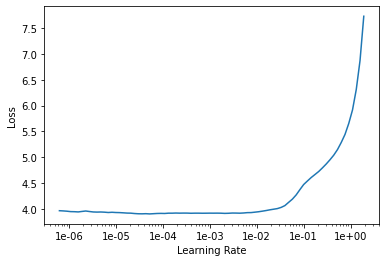

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.823978,3.927802,0.261936,07:46
1,3.772147,3.845878,0.272774,07:48
2,3.686621,3.806515,0.278729,07:47
3,3.559509,3.792720,0.281248,07:48
4,3.515564,3.794920,0.281319,07:47


In [30]:
learn.save_encoder('enc-stage-2')

In [31]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('enc-stage-2')
print(learn.predict('The product was', 5))
print(learn.predict('My shipment arrived', 5))

The product was delivered late but i noticed
My shipment arrived on time and with a


#### Create a Classifier

Now that we have a tuned language model, we move on to **creating a Classifier**.<br>
We'll first create a `DataBunch` for our classification problem. Notice that the **syntax is pretty much the same**, except that we **now use our star ratings as the labels**.

In [8]:
val_data = TextList.from_df(df_val, cols='review', vocab=data.vocab)

data_clas = (TextList.from_df(df_train, cols='review', vocab=data.vocab)
       .split_by_rand_pct(0.2, seed=2020)
       .label_from_df(cols='star_rating')
       .add_test(val_data)
       .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos a comfortable professional looking headset with a high quality microphone & speaker exceptional value but not quite perfect for those wanting a short review < br > < br > this review has turned out to be the longest i have ever written so i thought a short version might be in order for those with limited attention spans … i mean limited time  simply put the speaker,5
xxbos current monitor results for nexus 7 tab galaxy nexus phone samsung galaxy 77 tablet and ipad mini xxunk 42 amp is a two usb ports wall charger with retractable prongs to test this external battery i used a current monitor in addition to the current monitor i also used a 10 minute charging test to provide a less abstract measurements of this charger these tests allow me to compare,5
xxbos happy update of my previous review it works like a dream now update the kindly people at snugg sent me a new case frankly i was nt real xxunk about it i figured it would probably still have the design flaws that made it a worthless $ 20 investment but i was wrong wrong wrong that will show me to stop being such a xxunk i could nt be,5
xxbos * * updated notes towards the end of original review * * nokia lumia 521 metropcs bought from amazon not 3rd party vendor first off i just want to say that i purchased this through amazon not a third party vendor so my experience with this item is probably slightly different than other reviews why buy from amazon and not a 3rd party vendor well after reading some of,4
xxbos good for working people not for everyone nice sound was sent a wrong color my first impression is this is a really nice looking and high quality earphone but its not for everyone it was nt for me especially i bought these earphones because nowadays i m trying to go wireless on all my computer accessories i hate wires i do nt workout at all most of the time,3


In [32]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('enc-stage-2')
learn_classifier.freeze()
learn_classifier.fit_one_cycle(10)
learn_classifier.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.847336,0.695352,0.725250,04:07
1,0.815760,0.653389,0.747312,8:30:19
2,0.801872,0.648235,0.752437,04:05
3,0.803606,0.642513,0.748062,04:04
4,0.754694,0.626177,0.754125,04:13
5,0.715627,0.628537,0.753313,03:59
6,0.699694,0.621820,0.759562,03:57
7,0.744746,0.619439,0.757563,03:58
8,0.722054,0.621591,0.758563,04:02
9,0.747256,0.615466,0.759625,04:01


text,target,prediction
xxbos a nice phone but some drawbacks i got a chance to play around with an htc one m9 for the last couple of days i am a complete phone nerd and a recognized xxunk on xda developers where all kinds of android phone modifications are developed and discussed if that means anything to you so when i get a chance to play around with a new phone i jump,4,3
xxbos a great radar detector update feb 23 2014 < br > xxrep 19 _ i thought it only fair to update this review escort did rma my detector and replaced the gps chip in it i was without for xxunk 3 weeks but now i m using it daily since mid january and i can say it has performed excellently i love the auto xxunk of false alarms and,4,1
xxbos great unit for great price so far i have had this unit in for 1 day in my truck and i can tell you that the sound improvement over the stock system is nothing short of amazing for starters i have a 2006 gmc sierra it comes with the gm head unit onstar integrated and the bose amplifier for those in a similar situation as i you will have,5,5
xxbos makes iphone bulky but definitely is well protected i bought a factory unlocked iphone 4 and lets just say it was not cheap $ 1k coupled with the fact that i have a 15 month old son and a little clumsy well i definitely wanted to have my iphone super duper protected i ordered from amazon and had the free shipping amazon is great i got it relatively fast,5,4
xxbos ampen new hybrid stylus an updated product that works well using a stylus with various devices can be highly subjective but when you find one that works well for you its hard to do without it this one is a good example of taking a first rate product and making subtle improvements to make it truly excellent the xxunk ampen new hybrid stylus silver is an example of product,5,5


In [33]:
learn_classifier.save('sentiment-stage-1')

In [131]:
# learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learn_classifier.load_encoder('enc-stage-2')
learn_classifier.load('sentiment-stage-1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (64000 items)
x: TextList
xxbos good stuff i like the ease of use it is good for my needs i really like it a lot and would buy another,xxbos i recommend this phone on a scale from 1 to 10 i rate this phone a 9 i have been using this phone for about two weeks and i m enjoying everything about this phone from looks to functions i have purchase many similar phones blu alcatel and so on and this one holds its own against them and many others if your were to ask me the only reason i would say i d give it a 9 is that the loud speaker could be a tad louder because if you are in a noisey environment you may need your headphones all and all this is a perfect phone call quality wifi bluetooth pictures all perfect,xxbos great product very sturdy and does everything the ad says it does < br > best price was found at amazon < br > highly recommend it for i phones,xxbos work great in beginning but mount gets loose and can not remove worked great i

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 232, in _feed
    close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



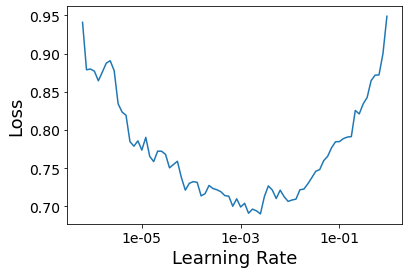

In [132]:
learn_classifier.freeze_to(-2)
learn_classifier.lr_find()
learn_classifier.recorder.plot()

In [133]:
learn_classifier.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.693067,0.600351,0.764000,04:36
1,0.683088,0.577081,0.769437,04:33
2,0.687134,0.566117,0.773750,04:33
3,0.608367,0.567810,0.774312,04:32
4,0.627051,0.567901,0.772563,04:31


In [134]:
learn_classifier.save('sentiment-stage-2')

In [9]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('enc-stage-2')
learn_classifier.load('sentiment-stage-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (64000 items)
x: TextList
xxbos good stuff i like the ease of use it is good for my needs i really like it a lot and would buy another,xxbos i recommend this phone on a scale from 1 to 10 i rate this phone a 9 i have been using this phone for about two weeks and i m enjoying everything about this phone from looks to functions i have purchase many similar phones blu alcatel and so on and this one holds its own against them and many others if your were to ask me the only reason i would say i d give it a 9 is that the loud speaker could be a tad louder because if you are in a noisey environment you may need your headphones all and all this is a perfect phone call quality wifi bluetooth pictures all perfect,xxbos great product very sturdy and does everything the ad says it does < br > best price was found at amazon < br > highly recommend it for i phones,xxbos work great in beginning but mount gets loose and can not remove worked great i

In [13]:
gc.collect()
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


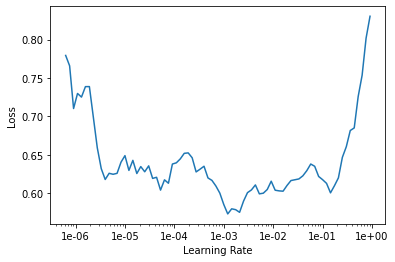

In [15]:
learn_classifier.freeze()
learn_classifier.freeze_to(-1)
learn_classifier.lr_find()
learn_classifier.recorder.plot()

In [16]:
learn_classifier.fit_one_cycle(5, slice(2e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.624201,0.562661,0.777500,03:58
1,0.592451,0.561295,0.776000,03:58
2,0.595493,0.560349,0.777313,03:58
3,0.599243,0.569242,0.774813,03:58
4,0.598938,0.560043,0.775250,04:02


In [17]:
learn_classifier.save('sentiment-stage-3')

#### Evaluate Model

We now check how well our model performed by predicting on our validation set.<br>
Note that we have to add 1 to our predictions to convert zero-indexed predictions (0 to 4) to Amazon star ratings (1 to 5).<br>

**Results:**
- The model performs very well for 1 and 5-star reviews. These are the easiest to predict.
- The model is not able to predict 2-4 star reviews well.
    - For 2 and 4-star reviews, the model has a hard time distinguishing these with 1 and 5-star reviews, respectively.
    - For 3-star reviews, the model get confused since this is 'neutral'. It gets half of these right, but assigns the other half anywhere from a 1 to a 5-star review.

In [18]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
preds = np.argmax(preds, axis=1)
preds += 1

In [19]:
learn_classifier.predict("Five stars")

(Category tensor(4),
 tensor(4),
 tensor([0.0048, 0.0185, 0.0280, 0.0257, 0.9230]))

In [83]:
learn_classifier.predict("Good product, however the shipping was delayed")

(Category tensor(2),
 tensor(2),
 tensor([0.1092, 0.2453, 0.3923, 0.1468, 0.1063]))

In [84]:
learn_classifier.predict("Would not recommend")

(Category tensor(0),
 tensor(0),
 tensor([0.6133, 0.3287, 0.0368, 0.0127, 0.0085]))

In [88]:
learn_classifier.predict("To the left to the left, everything you own in the box to the left")

(Category tensor(0),
 tensor(0),
 tensor([0.2724, 0.2589, 0.2586, 0.0678, 0.1423]))

In [39]:
accuracy_score(df_val.star_rating, preds)

0.76775

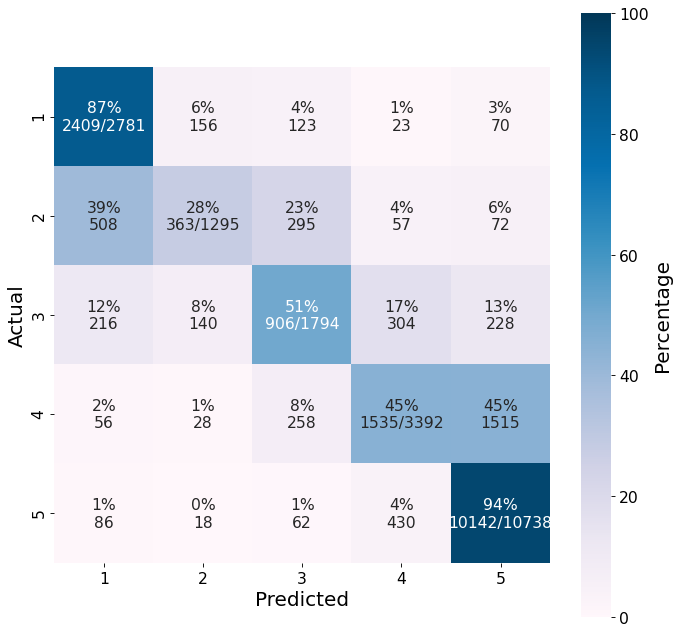

In [36]:
cm_analysis(df_val.star_rating, preds, data_clas.classes, pct_dec=0)

##### --END--
This ends my notebook for Sentiment Analysis using FastAI.